# Introduction to Boosting
References: 
- https://github.com/dmlc/xgboost/tree/master/demo/guide-python
- https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- http://xgboost.readthedocs.org/en/latest/parameter.html#general-parameters
- https://github.com/dmlc/xgboost/tree/master/demo/guide-python
- https://xgboost.readthedocs.io/en/latest/python/python_api.html

The term `Boosting` refers to a family of algorithms which converts weak learner to strong learners.

There are many boosting algorithms which impart additional boost to model’s accuracy. In this tutorial, we’ll learn about the two most commonly used algorithms i.e. Gradient Boosting (GBM) and XGboost.

Generally XGboost is considered more advanced than gbm. 
- xgboost supports regularization, however gbm does not.
- xgboost is blazingley faster than gbm.
- xgboost has built-in routine to handle missing values.
- xgboost has tree pruning mechanisms,however gbm and random forest are greedy algorithms and do not have tree pruning.
- In xgboost we can run cross-validation at each iteration of the boosting. But in gbm, we have to run grid search.

# Imports

In [0]:
import numpy as np
import pandas as pd

SEED = 100

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams.update({'font.size': 16})

plt.style.use('ggplot')
%matplotlib inline

In [0]:
import xgboost as xgb

In [0]:
# six and pickle
import six
import pickle
import joblib

In [0]:
# scale and split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

In [0]:
# classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [0]:
# sklearn scalar metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [0]:
# roc auc and curves
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve

In [0]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [0]:
import time

In [0]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, STATUS_FAIL
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
import copy
import pprint
pp = pprint.PrettyPrinter(indent=4)

# Useful Scripts

In [0]:
def show_method_attributes(obj, ncols=7,start=None, inside=None):
    """ Show all the attributes of a given method.
    Example:
    ========
    show_method_attributes(list)
     """
    lst = [elem for elem in dir(obj) if elem[0]!='_' ]
    lst = [elem for elem in lst 
           if elem not in 'os np pd sys time psycopg2'.split() ]

    if isinstance(start,str):
        lst = [elem for elem in lst if elem.startswith(start)]
        
    if isinstance(start,tuple) or isinstance(start,list):
        lst = [elem for elem in lst for start_elem in start
               if elem.startswith(start_elem)]
        
    if isinstance(inside,str):
        lst = [elem for elem in lst if inside in elem]
        
    if isinstance(inside,tuple) or isinstance(inside,list):
        lst = [elem for elem in lst for inside_elem in inside
               if inside_elem in elem]

    return pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')

In [0]:
df_eval = pd.DataFrame({'Model': [],
                        'Description':[],
                        'Accuracy':[],
                        'Precision':[],
                        'Recall':[],
                        'F1':[],
                        'AUC':[],
                    })

# Load the data

In [14]:
ifile = 'https://github.com/bhishanpdl/Project_Fraud_Detection/blob/master/data/raw/creditcard.csv.zip?raw=true'
df = pd.read_csv(ifile,compression='zip')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [15]:
target = 'Class'
df[target].value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

# Train test split with stratify

In [16]:
from sklearn.model_selection import train_test_split

Xtrain_orig, Xtest, ytrain_orig, ytest = train_test_split(
    df.drop(target,axis=1), 
    df[target],
    test_size=0.2, 
    random_state=SEED, 
    stratify=df[target])

df_Xtrain_orig = pd.DataFrame(Xtrain_orig, columns=df.columns.drop(target))
df_Xtest = pd.DataFrame(Xtest, columns=df.columns.drop(target))

print(df_Xtrain_orig.shape)
df_Xtrain_orig.head()

(227845, 30)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
211885,138616.0,-1.137612,2.345154,-1.767247,0.833982,0.973168,-0.073571,0.802433,0.733137,-1.154087,-0.520340,0.494117,0.799935,0.494576,-0.479666,-0.917177,-0.184117,1.189459,0.937244,0.960749,0.062820,0.114953,0.430613,-0.240819,0.124011,0.187187,-0.402251,0.196277,0.190732,39.46
12542,21953.0,-1.028649,1.141569,2.492561,-0.242233,0.452842,-0.384273,1.256026,-0.816401,1.964560,-0.014216,0.432153,-2.140921,2.274477,0.114128,-1.652894,-0.617302,0.243791,-0.426168,-0.493177,0.350032,-0.380356,-0.037432,-0.503934,0.407129,0.604252,0.233015,-0.433132,-0.491892,7.19
270932,164333.0,-1.121864,-0.195099,1.282634,-3.172847,-0.761969,-0.287013,-0.586367,0.496182,-2.352349,0.350551,-1.319688,-0.942001,1.082210,-0.425735,0.036748,0.380392,-0.033353,0.204609,-0.801465,-0.113632,-0.328953,-0.856937,-0.056198,0.401905,0.406813,-0.440140,0.152356,0.030128,40.00
30330,35874.0,1.094238,-0.760568,-0.392822,-0.611720,-0.722850,-0.851978,-0.185505,-0.095131,-1.122304,0.367009,1.378493,-0.724216,-1.105406,-0.480170,0.220826,1.745743,0.740817,-0.728827,1.016740,0.354148,-0.227392,-1.254285,0.022116,-0.141531,0.114515,-0.652427,-0.037897,0.051254,165.85
272477,165107.0,2.278095,-1.298924,-1.884035,-1.530435,-0.649500,-0.996024,-0.466776,-0.438025,-1.612665,1.631133,-1.126000,-0.938760,0.300621,-0.119667,-0.585453,-1.106244,0.690235,-0.124401,-0.075649,-0.341708,0.123892,0.815909,-0.072537,0.784217,0.403428,0.193747,-0.043185,-0.058719,60.00


# Train Validation with stratify

In [17]:
Xtrain, Xvalid, ytrain, yvalid = train_test_split(
    Xtrain_orig, 
    ytrain_orig,
    test_size=0.2, 
    random_state=SEED, 
    stratify=ytrain_orig)

df_Xtrain = pd.DataFrame(Xtrain, columns=df.columns.drop(target))
df_Xvalid = pd.DataFrame(Xvalid, columns=df.columns.drop(target))

print(df_Xtrain.shape)

(182276, 30)


In [18]:
# random undersampling
n = df[target].value_counts().values[-1]
df_under = (df.groupby(target)
                .apply(lambda x: x.sample(n,random_state=SEED))
                .reset_index(drop=True))

Xtrain_orig_under, Xtest_under, ytrain_orig_under, ytest_under = train_test_split(
    df_under.drop(target,axis=1),
    df_under[target],
    test_size=0.2, 
    random_state=SEED, 
    stratify=df_under[target])

df_Xtrain_orig_under = pd.DataFrame(Xtrain_orig_under, columns=df_under.columns.drop(target))
df_Xtest_under = pd.DataFrame(Xtest_under, columns=df_under.columns.drop(target))


Xtrain_under, Xvalid_under, ytrain_under, yvalid_under = train_test_split(
    Xtrain_orig_under,
    ytrain_orig_under,
    test_size=0.2, 
    random_state=SEED, 
    stratify=ytrain_orig_under)



df_Xtrain_under = pd.DataFrame(Xtrain_under, columns=df_under.columns.drop(target))
df_Xvalid_under = pd.DataFrame(Xvalid_under, columns=df_under.columns.drop(target))


ytrain.value_counts(), ytest.value_counts(), yvalid.value_counts()

(0    181961
 1       315
 Name: Class, dtype: int64, 0    56864
 1       98
 Name: Class, dtype: int64, 0    45490
 1       79
 Name: Class, dtype: int64)

# Modelling xgboost imbalanced data
```
Parameters:
-------------
max_depth=3
learning_rate=0.1
n_estimators=100
verbosity=1 **NOTE: it print in ipython terminal not in browser
silent=None **deprecated use verbosity
objective='binary:logistic' **for binary classification
booster='gbtree' **use default tree not linear
n_jobs=1 **make this -1
nthread=None **deprecated use n_jobs
gamma=0
min_child_weight=1
max_delta_step=0
subsample=1
colsample_bytree=1
colsample_bylevel=1
colsample_bynode=1
reg_alpha=0
reg_lambda=1
scale_pos_weight=1
base_score=0.5
random_state=0 **use your own random state
seed=None      **deprecated use random_state
missing=None
```


[early stopping xgboost official note](https://xgboost.readthedocs.io/en/latest/python/python_intro.html):  


If early stopping occurs, the model will have three additional fields: bst.best_score, bst.best_iteration and bst.best_ntree_limit.
 Note that xgboost.train() will return a model from the last iteration, not the best one.
[Example](https://github.com/dmlc/xgboost/blob/master/demo/guide-python/sklearn_examples.py)
```python
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, early_stopping_rounds=10, eval_metric="auc",
        eval_set=[(X_test, y_test)])

```

In [0]:
# help(XGBClassifier)

Time taken: 0 min 46 secs


,Model,Description,Accuracy,Precision,Recall,F1,AUC
0,Xgboost,"default, imbalanced",0.999263,0.999263,0.999263,0.999263,0.846833


[[56852    12]
 [   30    68]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.69      0.76        98

    accuracy                           1.00     56962
   macro avg       0.92      0.85      0.88     56962
weighted avg       1.00      1.00      1.00     56962



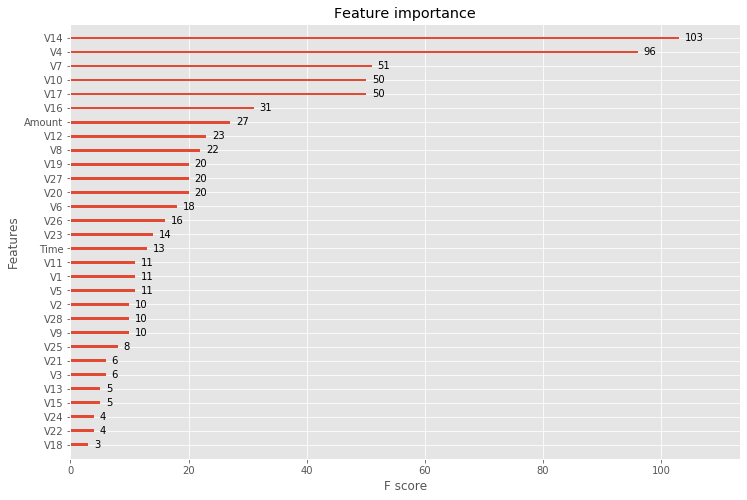

In [20]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score,  precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix

time_start = time.time()
# model fit
clf_xgb = XGBClassifier(n_jobs=-1, random_state=SEED,
                        objective='binary:logistic')

clf_xgb.fit(df_Xtrain, ytrain)
default = """
[[56852    12]
 [   30    68]]

"""

# clf_xgb.fit(df_Xtrain,ytrain,
#             eval_set=[(df_Xvalid,yvalid)],
#             eval_metric='auc',
#             early_stopping_rounds=30, # early stopping gives 
#             )
early30 = """

[[56852    12]
 [   30    68]]
"""


# predictions
skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=SEED)
ypreds_cv = cross_val_predict(clf_xgb, Xtest, ytest, cv=skf)
ypreds = ypreds_cv



# model evaluation
row_eval = ['Xgboost','default, imbalanced', 
            accuracy_score(ytest, ypreds),
            precision_score(ytest, ypreds, average='micro'),
            recall_score(ytest, ypreds, average='micro'),
            f1_score(ytest, ypreds, average='micro'),
            roc_auc_score(ytest, ypreds),
       ]

df_eval.loc[len(df_eval)] = row_eval
df_eval = df_eval.drop_duplicates()
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
display(df_eval)

# confusion matrix
print(confusion_matrix(ytest, ypreds))
print(classification_report(ytest,ypreds))

# feature importance
fig,ax = plt.subplots(figsize=(12,8))
xgb.plot_importance(clf_xgb,ax=ax)
plt.show()

# Xgboost modelling Undersampled data

In [21]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score,  precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix

time_start = time.time()
# model fit
clf_xgb = XGBClassifier(n_jobs=-1, random_state=SEED,
                        objective='binary:logistic')

clf_xgb.fit(df_Xtrain_under, ytrain_under)


# predictions
skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=SEED)
ypreds_cv = cross_val_predict(clf_xgb, Xtest_under, ytest_under, cv=skf)
ypreds_under = ypreds_cv

# model evaluation
row_eval = ['Xgboost','default, undersample', 
            accuracy_score(ytest_under, ypreds_under),
            precision_score(ytest_under, ypreds_under, average='micro'),
            recall_score(ytest_under, ypreds_under, average='micro'),
            f1_score(ytest_under, ypreds_under, average='micro'),
            roc_auc_score(ytest_under, ypreds_under),
       ]

df_eval.loc[len(df_eval)] = row_eval
df_eval = df_eval.drop_duplicates()
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
display(df_eval)

# confusion matrix
print(confusion_matrix(ytest_under, ypreds_under))
print(classification_report(ytest_under,ypreds_under))

Time taken: 0 min 0 secs


,Model,Description,Accuracy,Precision,Recall,F1,AUC
0,Xgboost,"default, imbalanced",0.999263,0.999263,0.999263,0.999263,0.846833
1,Xgboost,"default, undersample",0.944162,0.944162,0.944162,0.944162,0.943981


[[97  2]
 [ 9 89]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        99
           1       0.98      0.91      0.94        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197



# Xgboost modelling Undersampled data with n_estimators = 150

In [22]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score,  precision_score, recall_score,f1_score
from sklearn.metrics import confusion_matrix

time_start = time.time()
# model fit
clf_xgb = XGBClassifier(n_jobs=-1, random_state=SEED,
                        objective='binary:logistic',
                        n_estimators=150)

clf_xgb.fit(df_Xtrain_under, ytrain_under)


# predictions
skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=SEED)
ypreds_cv = cross_val_predict(clf_xgb, Xtest_under, ytest_under, cv=skf)
ypreds_under = ypreds_cv

# model evaluation
row_eval = ['Xgboost','undersample, n_estimators=150', 
            accuracy_score(ytest_under, ypreds_under),
            precision_score(ytest_under, ypreds_under, average='micro'),
            recall_score(ytest_under, ypreds_under, average='micro'),
            f1_score(ytest_under, ypreds_under, average='micro'),
            roc_auc_score(ytest_under, ypreds_under),
       ]

df_eval.loc[len(df_eval)] = row_eval
df_eval = df_eval.drop_duplicates()
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
display(df_eval)

# confusion matrix
print(confusion_matrix(ytest_under, ypreds_under))
print(classification_report(ytest_under,ypreds_under))

Time taken: 0 min 0 secs


,Model,Description,Accuracy,Precision,Recall,F1,AUC
0,Xgboost,"default, imbalanced",0.999263,0.999263,0.999263,0.999263,0.846833
1,Xgboost,"default, undersample",0.944162,0.944162,0.944162,0.944162,0.943981
2,Xgboost,"undersample, n_estimators=150",0.954315,0.954315,0.954315,0.954315,0.954082


[[99  0]
 [ 9 89]]
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        99
           1       1.00      0.91      0.95        98

    accuracy                           0.95       197
   macro avg       0.96      0.95      0.95       197
weighted avg       0.96      0.95      0.95       197



# HPO (Hyper Parameter Optimization)

**Important Parameters**:

- learning_rate: step size shrinkage used to prevent overfitting. Range is [0,1]
- max_depth: determines how deeply each tree is allowed to grow during any boosting round.
- subsample: percentage of samples used per tree. Low value can lead to underfitting.
- colsample_bytree: percentage of features used per tree. High value can lead to overfitting.
- n_estimators: number of trees you want to build.


**Regularization parameters**:

- gamma: controls whether a given node will split based on the expected reduction in loss after the split. A higher value leads to fewer splits. Supported only for tree-based learners.
- alpha: L1 regularization on leaf weights. A large value leads to more regularization.
- lambda: L2 regularization on leaf weights and is smoother than L1 regularization.

In [0]:
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK, STATUS_FAIL
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample
import copy
import pprint
pp = pprint.PrettyPrinter(indent=4)

def hpo_hyperopt(param_space, Xtrain, ytrain, Xtest, ytest, num_eval,cv=3):
    """HPO using hyperopt package.

    Hyper Parameter Optimation using Bayesian methods.

    Usage:
    -------
    num_eval = 500 # number of evaluations
    param_hyperopt = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    'n_estimators': scope.int(hp.quniform('n_estimators', 50, 1000, 50)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.2, 1.0),
    'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
    }


    trials, dict_best_params1 = hpo_hyperopt(param_hyperopt,
                                Xtrain_under, ytrain_under,
                                Xtest_under, ytest_under, num_eval)

    clf_xgb = XGBClassifier(n_jobs=-1, random_state=SEED,
                        objective='binary:logistic',
                        **dict_best_params1)

    """
    # time
    time_start = time.time()
    
    # define objective function
    def objective_function(params):
        model = xgb.XGBClassifier(**params)
        score = cross_val_score(model, Xtrain, ytrain, cv=cv).mean()
        return {'loss': -score, 'status': STATUS_OK}

    # keep track of trials
    trials = Trials()

    # best params
    best_param = fmin(objective_function, 
                      param_space, 
                      algo=tpe.suggest, 
                      max_evals=num_eval, 
                      trials=trials,
                      rstate= np.random.RandomState(SEED))
    
    # dict best params
    dict_best_params = copy.copy(best_param)

    if 'boosting_type' in dict_best_params: 
        dict_best_params['boosting_type'] = 'gbdt' if dict_best_params['boosting_type'] == 0 else 'dart'


    int_params = ['max_depth','num_leaves','n_estimators']

    for int_param in int_params:
        # make integer if exist
        if int_param in dict_best_params:
            dict_best_params[int_param] = int(dict_best_params[int_param])
    
    # loss
    loss = [x['result']['loss'] for x in trials.trials]

    # best model    
    model_best = xgb.XGBClassifier(**dict_best_params)                      
    model_best.fit(Xtrain, ytrain)

    time_taken = time.time() - time_start
    
    print("\nResults\n" + '='*50)
    print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
    print("Number of parameter combinations tested: ", num_eval)
    print("Train Score Best                       : {:.4f} ".format(min(loss)*-1))
    print("Test Score                             : {:.4f} ".format(model_best.score(Xtest, ytest)))
    print("Best parameters:")
    pp.pprint(dict_best_params)
    
    return trials, dict_best_params

In [24]:
num_eval = 50 # number of evaluations
param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    # 'n_estimators': scope.int(hp.quniform('n_estimators', 150, 151, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.2, 1.0),
    'subsample': hp.uniform ('subsample', 0.7, 1),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
    # regularization
    # 'reg_alpha': hp.uniform('reg_alpha', 0.0, 0.1),
    # 'reg_lambda': hp.uniform('reg_lambda', 0.0, 0.1),
    # 'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    'gamma' : hp.uniform ('x_gamma', 0.1,0.5),
}


trials, dict_best_params = hpo_hyperopt(param_hyperopt, 
                                Xtrain_under, ytrain_under,
                                Xtest_under, ytest_under, num_eval)

# override best params
# dict_best_params['boosting_type'] = 'gbdt'
time_start = time.time()
# model fit
clf_xgb = XGBClassifier(n_jobs=-1, random_state=SEED,
                        objective='binary:logistic',
                        n_estimators=150,
                        **dict_best_params)

print(clf_xgb)
clf_xgb.fit(df_Xtrain_under, ytrain_under)


# predictions
skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=SEED)
ypreds_cv = cross_val_predict(clf_xgb, Xtest_under, ytest_under, cv=skf)
ypreds_under = ypreds_cv

# model evaluation
row_eval = ['Xgboost','undersample, hpo1', 
            accuracy_score(ytest_under, ypreds_under),
            precision_score(ytest_under, ypreds_under, average='micro'),
            recall_score(ytest_under, ypreds_under, average='micro'),
            f1_score(ytest_under, ypreds_under, average='micro'),
            roc_auc_score(ytest_under, ypreds_under),
       ]

df_eval.loc[len(df_eval)] = row_eval
df_eval = df_eval.drop_duplicates()
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
display(df_eval)

# confusion matrix
print(confusion_matrix(ytest_under, ypreds_under))
print(classification_report(ytest_under,ypreds_under))

100%|██████████| 50/50 [00:11<00:00,  3.68it/s, best loss: -0.9316700843016633]

Results
Time taken: 0 min 12 secs
Number of parameter combinations tested:  50
Train Score Best                       : 0.9317 
Test Score                             : 0.9391 
Best parameters:
{   'boosting_type': 'dart',
    'colsample_by_tree': 0.6572282885949191,
    'learning_rate': 0.08125316309250195,
    'max_depth': 14,
    'min_child_weight': 4.0,
    'num_leaves': 8,
    'subsample': 0.7847729344095749,
    'x_gamma': 0.33281913864021795}
XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='dart',
              colsample_by_tree=0.6572282885949191, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.08125316309250195, max_delta_step=0, max_depth=14,
              min_child_weight=4.0, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, num_leaves=8, objective='binary:logistic',
              random_state=1

,Model,Description,Accuracy,Precision,Recall,F1,AUC
0,Xgboost,"default, imbalanced",0.999263,0.999263,0.999263,0.999263,0.846833
1,Xgboost,"default, undersample",0.944162,0.944162,0.944162,0.944162,0.943981
2,Xgboost,"undersample, n_estimators=150",0.954315,0.954315,0.954315,0.954315,0.954082
3,Xgboost,"undersample, hpo1",0.944162,0.944162,0.944162,0.944162,0.943981


[[97  2]
 [ 9 89]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        99
           1       0.98      0.91      0.94        98

    accuracy                           0.94       197
   macro avg       0.95      0.94      0.94       197
weighted avg       0.95      0.94      0.94       197



# HPO Notes
```python
num_eval = 50
param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    # 'n_estimators': scope.int(hp.quniform('n_estimators', 150, 151, 1)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.2, 1.0),
    'subsample': hp.uniform ('subsample', 0.7, 1),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
    # regularization
    #'reg_alpha': hp.uniform('reg_alpha', 0.0, 1.0),
    #'reg_lambda': hp.uniform('reg_lambda', 0.0, 1.0),
}
[[97  2]
 [ 8 90]]
 XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='dart',
              colsample_by_tree=0.425706475356356, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.04110731401631858, max_delta_step=0, max_depth=11,
              min_child_weight=10.0, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, num_leaves=46, objective='binary:logistic',
              random_state=100, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=None, subsample=0.9164366853711832,
              verbosity=1)
              

**Warning** 
with same params but increasing num_eval to 500 gives worse result:
[97  2]
 [10 88]]
```

# HPO for imbalanced data

In [25]:
num_eval = 10 # number of evaluations
param_hyperopt= {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(1)),
    'max_depth': scope.int(hp.quniform('max_depth', 5, 15, 1)),
    # 'n_estimators': scope.int(hp.quniform('n_estimators', 100, 500, 50)),
    'num_leaves': scope.int(hp.quniform('num_leaves', 5, 50, 1)),
    'boosting_type': hp.choice('boosting_type', ['gbdt', 'dart']),
    'colsample_bytree': hp.uniform('colsample_by_tree', 0.2, 1.0),
    'subsample': hp.uniform ('subsample', 0.7, 1),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
    # regularization
    # 'reg_alpha': hp.uniform('reg_alpha', 0.0, 0.1),
    # 'reg_lambda': hp.uniform('reg_lambda', 0.0, 0.1),
    # 'gamma' : hp.quniform('gamma', 0, 0.50, 0.01),
    # 'gamma' : hp.uniform ('gamma', 0.1,0.5),
}


trials, dict_best_params = hpo_hyperopt(param_hyperopt,
                                Xtrain, ytrain,
                                Xtest, ytest, num_eval)

# override best params
# dict_best_params1['boosting_type'] = 'gbdt'
time_start = time.time()
# model fit
clf_xgb = XGBClassifier(n_jobs=-1, random_state=SEED,
                        objective='binary:logistic',
                        n_estimators=150,
                        **dict_best_params)

print(clf_xgb)
clf_xgb.fit(df_Xtrain, ytrain)


# predictions
skf = StratifiedKFold(n_splits=2,shuffle=True,random_state=SEED)
ypreds_cv = cross_val_predict(clf_xgb, Xtest, ytest, cv=skf)
ypreds = ypreds_cv

# model evaluation
row_eval = ['Xgboost','imbalanced, hpo', 
            accuracy_score(ytest, ypreds),
            precision_score(ytest, ypreds, average='micro'),
            recall_score(ytest, ypreds, average='micro'),
            f1_score(ytest, ypreds, average='micro'),
            roc_auc_score(ytest, ypreds),
       ]

df_eval.loc[len(df_eval)] = row_eval
df_eval = df_eval.drop_duplicates()
time_taken = time.time() - time_start
print('Time taken: {:.0f} min {:.0f} secs'.format(*divmod(time_taken,60)))
display(df_eval)

# confusion matrix
print(confusion_matrix(ytest, ypreds))
print(classification_report(ytest,ypreds))

100%|██████████| 50/50 [1:09:44<00:00, 78.38s/it, best loss: -0.9995830502716553]

Results
Time taken: 70 min 57 secs
Number of parameter combinations tested:  50
Train Score Best                       : 0.9996 
Test Score                             : 0.9995 
Best parameters:
{   'boosting_type': 'gbdt',
    'colsample_by_tree': 0.8087884262626683,
    'learning_rate': 0.40737521068237276,
    'max_depth': 7,
    'min_child_weight': 1.0,
    'num_leaves': 44,
    'subsample': 0.9103436118236479}
XGBClassifier(base_score=0.5, booster='gbtree', boosting_type='gbdt',
              colsample_by_tree=0.8087884262626683, colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.40737521068237276, max_delta_step=0, max_depth=7,
              min_child_weight=1.0, missing=None, n_estimators=150, n_jobs=-1,
              nthread=None, num_leaves=44, objective='binary:logistic',
              random_state=100, reg_alpha=0, reg_lambda=1, sc

,Model,Description,Accuracy,Precision,Recall,F1,AUC
0,Xgboost,"default, imbalanced",0.999263,0.999263,0.999263,0.999263,0.846833
1,Xgboost,"default, undersample",0.944162,0.944162,0.944162,0.944162,0.943981
2,Xgboost,"undersample, n_estimators=150",0.954315,0.954315,0.954315,0.954315,0.954082
3,Xgboost,"undersample, hpo1",0.944162,0.944162,0.944162,0.944162,0.943981
4,Xgboost,"imbalanced, hpo",0.999333,0.999333,0.999333,0.999333,0.846868


[[56856     8]
 [   30    68]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.89      0.69      0.78        98

    accuracy                           1.00     56962
   macro avg       0.95      0.85      0.89     56962
weighted avg       1.00      1.00      1.00     56962

